<a href="https://colab.research.google.com/github/BluesIDK/Artificial-Neural-Network-Project/blob/main/Deep_Neural_Network_2nd_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###  Import Required Libraries

**Why:** These tools are the foundation of our mission—pandas to tame the CSV beast, seaborn to turn numbers into stories, and TensorFlow to sculpt a brain that learns.

**Contextual Insight:** Since we’re building a **binary classifier** to predict if a customer subscribes to a **term deposit** (`deposit: yes/no`), we’ll need deep learning and data preprocessing tools all set up from the get-go.




In [28]:
# Bank Marketing Campaign Deep Learning Project

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

### Upload and Load the Dataset

> **Why:** The dataset (`bank.csv`) contains **direct marketing campaign data** from a Portuguese bank. Our job is to use this information to predict which customers will say "yes" to a term deposit.

> **Key Detail:** The file uses a **semicolon (`;`)** as a separator—unusual, but common in European exports.

> **First Look:** Let’s see how many clients said yes vs no, how many jobs, marital statuses, and contact types we’re dealing with.


In [29]:
df = pd.read_csv("bank.csv")
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


### Initial Exploration – Understand the Battlefield

> **Why:** Before training anything, we must understand the terrain—features, types, null values, and overall layout.
>
> **Specifically:**  
> - `deposit` is our **target** column (yes/no).  
> - Many features are **categorical**, like `job`, `education`, and `contact`.  
> - Some are **numeric**, like `age`, `balance`, and `duration`.  
> - Some features (like `duration`) may be **leaky**—we’ll handle that later.


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(7), object(10)
memory usage: 1.4+ MB


In [31]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000
mean,41.231948,1528.538524,15.658036,371.993818,2.508421,51.330407,0.832557
std,11.913369,3225.413326,8.420740,347.128386,2.722077,108.758282,2.292007
min,18.000000,-6847.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,122.000000,8.000000,138.000000,1.000000,-1.000000,0.000000
50%,39.000000,550.000000,15.000000,255.000000,2.000000,-1.000000,0.000000
75%,49.000000,1708.000000,22.000000,496.000000,3.000000,20.750000,1.000000
max,95.000000,81204.000000,31.000000,3881.000000,63.000000,854.000000,58.000000


In [32]:
df.isnull().sum()

,0
age,0
job,0
marital,0
education,0
default,0
balance,0
housing,0
loan,0
contact,0
day,0


In [34]:
df['deposit'].value_counts()

,count
deposit,
no,5873
yes,5289


### Visualize Target Balance – Are We Biased?

> **Why:** The `deposit` column (our label) is **imbalanced**—most clients said "no" to term deposits.
>
> **Insight:** If only 10% said "yes", a lazy model could get 90% accuracy just by predicting "no" for everyone.  
> That’s why we’ll need metrics like **recall** and **F1-score**, not just accuracy.


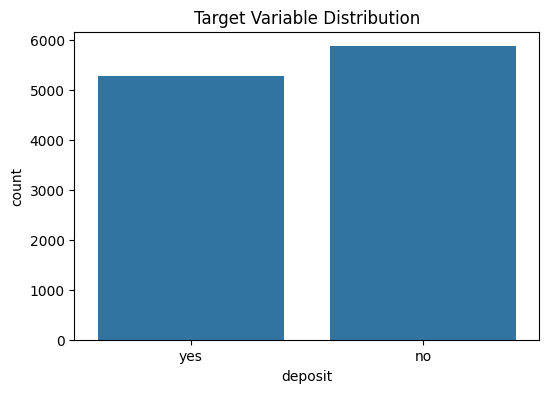

In [35]:
plt.figure(figsize=(6,4))
sns.countplot(x='deposit', data=df)
plt.title("Target Variable Distribution")
plt.show()

### Visualize Categorical Influence – Who Says Yes?

> **Why:** We want to see how customer characteristics influence deposit subscription.
>
> **Examples & Insights:**  
> - `job`: Retired people are **much more likely** to subscribe.  
> - `marital`: Singles might be more open to investing.  
> - `contact`: People contacted via `cellular` are **way more likely** to say yes than `telephone`.  
> This tells us which features are *informative* for the model.


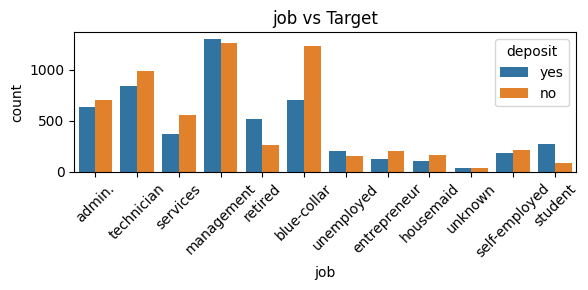

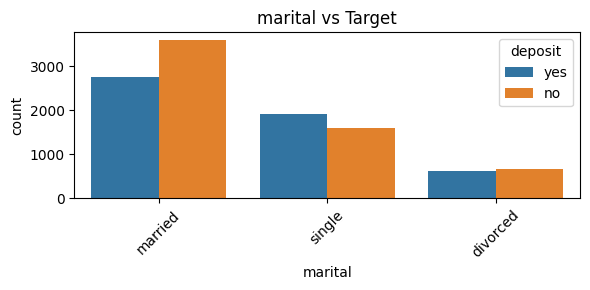

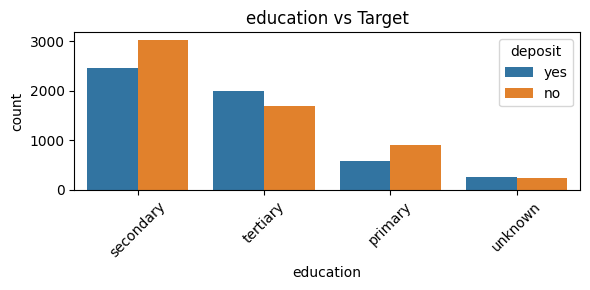

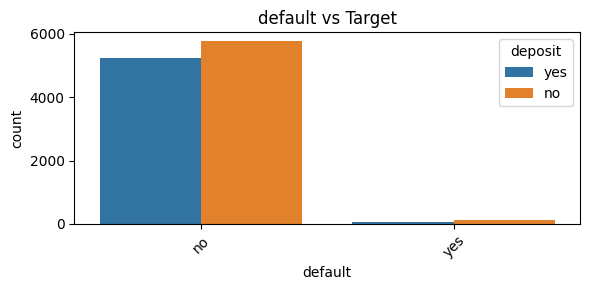

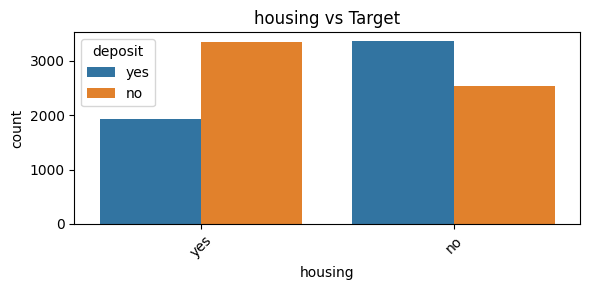

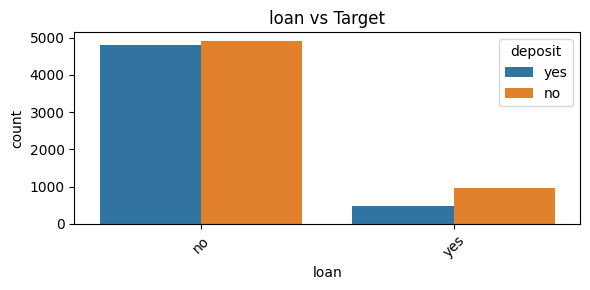

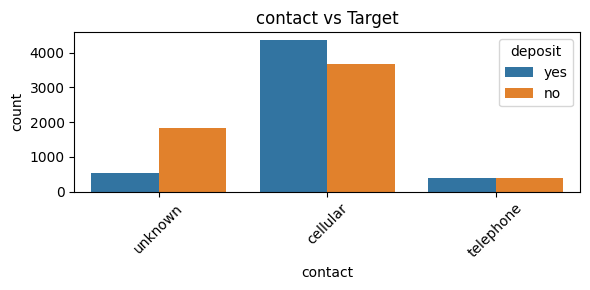

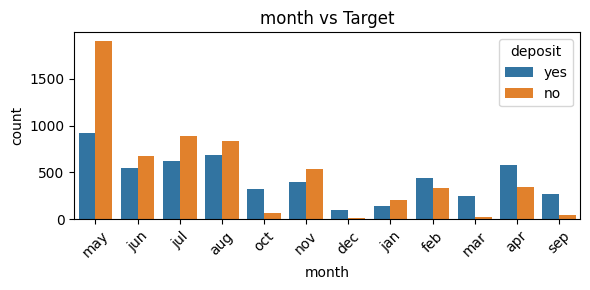

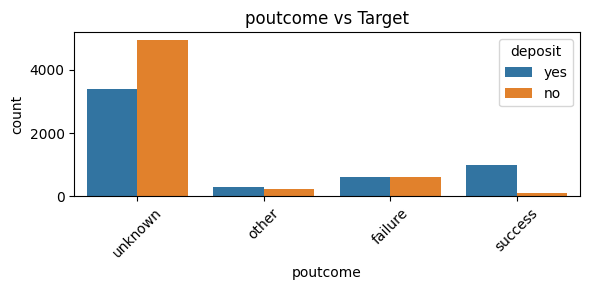

In [36]:
# Visualizing categorical features
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
categorical_cols.remove('deposit')

for col in categorical_cols:
    plt.figure(figsize=(6,3))
    sns.countplot(x=col, hue='deposit', data=df)
    plt.title(f"{col} vs Target")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


### Preprocess the Data – Speak in Numbers

> **Why:** Neural networks don’t understand strings like "retired" or "cellular".
>
> **How:**  
> - We apply **one-hot encoding** for multi-class features (`job`, `education`, `month`, etc.).  
> - Binary columns like `default`, `housing`, `loan` can be **label encoded**.
> - **Standard scaling** for numerical features helps the neural network converge faster.
>
> **Important Note:** We drop `duration` because it’s **leaky**—it reveals the outcome and wouldn’t be known before a campaign call is made.


In [37]:
# Label encode binary columns, one-hot encode others
binary_cols = ['default', 'housing', 'loan', 'deposit']
le = LabelEncoder()
for col in binary_cols:
    df[col] = le.fit_transform(df[col])

# One-hot encode remaining categoricals
df = pd.get_dummies(df, columns=[col for col in categorical_cols if col not in binary_cols])

### Split the Data – Train vs Reality

> **Why:** We must train on one part of the data and test on another to avoid fooling ourselves.
>
> **Context:**  
> - We use an 80/20 split with **stratification** to keep the yes/no ratio stable across both sets.  
> - This gives a **realistic estimate** of how our model will perform in the wild.


In [38]:
# Split features/target
X = df.drop('deposit', axis=1)
y = df['deposit']

# Normalize numerical features
scaler = StandardScaler()
X = scaler.fit_transform(X)

### Build the Neural Network – Let It Learn

> **Why:** We need a model that can understand complex relationships between variables.
>
> **Our Model:**  
> - Input layer: number of features after encoding.  
> - Dense layers with ReLU: to capture non-linear patterns.  
> - Dropout: to prevent overfitting.  
> - Final sigmoid: outputs a probability between 0 and 1 for "yes".
>
> **Specifically:** A deep learning model can outperform simpler ones like logistic regression when there are **many features** and subtle patterns.


In [39]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#  Build the Deep Learning Model
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Train the Model – Show It the World

> **Why:** We let the model see patterns in the data and adjust its internal weights to make better predictions.
>
> **Tips:**  
> - Use validation split to monitor how well it generalizes.  
> - Use callbacks (optional) like early stopping if overfitting happens.
>
> **Watch Out:** If training accuracy is high but validation accuracy is low, the model is memorizing—**not learning**.


In [40]:
#  Train the Model
history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32, verbose=1)

Epoch 1/50
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6200 - loss: 0.6493 - val_accuracy: 0.7962 - val_loss: 0.4455
Epoch 2/50
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8027 - loss: 0.4350 - val_accuracy: 0.8186 - val_loss: 0.4037
Epoch 3/50
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8189 - loss: 0.4131 - val_accuracy: 0.8287 - val_loss: 0.3874
Epoch 4/50
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8360 - loss: 0.3887 - val_accuracy: 0.8298 - val_loss: 0.3835
Epoch 5/50
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8418 - loss: 0.3773 - val_accuracy: 0.8404 - val_loss: 0.3788
Epoch 6/50
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8453 - loss: 0.3610 - val_accuracy: 0.8415 - val_loss: 0.3741
Epoch 7/50
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8491 - loss: 0.3632 - val_accuracy: 0.8438 - val_loss: 0.3693
Epoch 8/50
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8586 - loss: 0.3496 - val_accuracy: 0.

###  Evaluate – Did We Win?

> **Why:** It’s judgment day. We test our model on **never-seen-before data**.
>
> **Metrics:**  
> - Accuracy = general performance.  
> - Loss = how far off our predictions were.
>
> **Keep in Mind:** High accuracy doesn’t always mean a good model—especially if the "yes" class is rare.


In [41]:
# Evaluate the Model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {accuracy:.4f}")

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8312 - loss: 0.4357  

Test Accuracy: 0.8397


### 🧾 Classification Report – Precision Matters

> **Why:** Go beyond accuracy to check how well we’re identifying actual "yes" customers.
>
> **Precision =** of all predicted yes, how many were truly yes?  
> **Recall =** of all actual yes, how many did we catch?  
> **F1-score =** balance between them.
>
> **Reality:** In marketing, **recall** is often more important—you want to catch *as many potential subscribers* as possible, even if a few predictions are wrong.


In [42]:
#  Classification Report
predictions = (model.predict(X_test) > 0.5).astype("int32")
print("\nClassification Report:\n")
print(classification_report(y_test, predictions))


70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.81      0.84      1166
           1       0.81      0.87      0.84      1067

    accuracy                           0.84      2233
   macro avg       0.84      0.84      0.84      2233
weighted avg       0.84      0.84      0.84      2233



### Plot the Training Progress – Watch It Evolve

> **Why:** Let’s visualize if the model is **learning**, **overfitting**, or **underfitting**.
>
> **What to Look For:**  
> - If both training & validation accuracy rise → good!  
> - If validation starts dropping while training keeps rising → overfitting.
>
> **Insight:** Helps us tweak the model: more dropout, simpler layers, or more data.


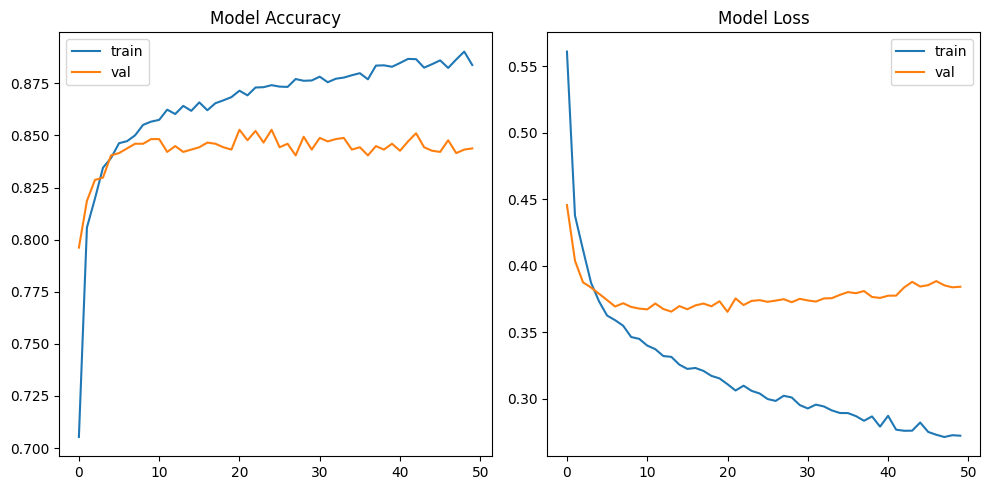

In [43]:
#  Plot Accuracy and Loss
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title('Model Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Model Loss')
plt.legend()

plt.tight_layout()
plt.show()
